In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

Загрузим данные в датафреймы


In [82]:
i124 = pd.read_csv("И124.prn", sep=r"\s+", header=None, names=["X", "Y"], encoding="utf-8")
i4529 = pd.read_csv("И4529.prn", sep=r"\s+", header=None, names=["X", "Y"], encoding="utf-8")
rb122 = pd.read_csv("РБ122.prn", sep=r"\s+", header=None, names=["X", "Y"], encoding="utf-8")

In [83]:
i124['X'] = i124['X'] / 100
i124['Y'] = i124['Y'] / 10
i4529['X'] = i4529['X'] / 100
i4529['Y'] = i4529['Y'] / 10
rb122['X'] = rb122['X'] / 100
rb122['Y'] = rb122['Y'] / 100

In [84]:
i124

,X,Y
0,0.005,102.015647
1,0.010,101.358627
2,0.015,100.146468
3,0.020,99.928787
4,0.025,94.304523
...,...,...
29995,149.980,-1.096949
29996,149.985,0.465789
29997,149.990,1.701307
29998,149.995,-2.929679


In [85]:
spectrums = [i124, i4529, rb122]
spectrums_names = ['i124', 'i4529', 'rb122']
for spec, name in zip(spectrums, spectrums_names):
    globals()[name + 'X'] = spec.X.to_numpy().reshape(-1, 1)
    globals()[name + 'Y'] = spec.Y.to_numpy().reshape(-1, 1)

Отобразим релаксационные кривые для всех образцов

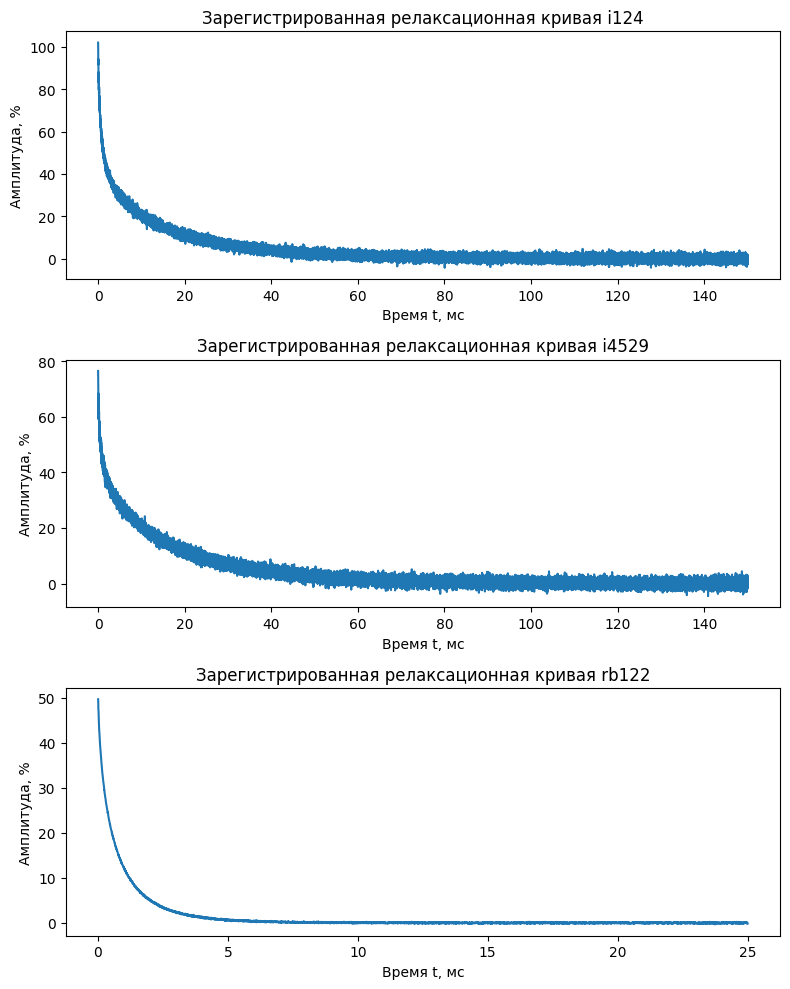

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))


for ax, data, name in zip(axes, spectrums, spectrums_names):
    ax.plot(data.X, data.Y)
    ax.set_title(f'Зарегистрированная релаксационная кривая {name}')
    ax.set_ylabel('Амплитуда, %')
    ax.set_xlabel('Время t, мс')
    

plt.tight_layout()
plt.show()


Зададим временную сетку в диапазоне от 0.1 до 1000, 
разбитой в логарифмическом масштабе на 50 штук:

In [87]:
T2 = np.logspace(-1, 3, 50)
T2

array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+00, 1.67683294e+00,
       2.02358965e+00, 2.44205309e+00, 2.94705170e+00, 3.55648031e+00,
       4.29193426e+00, 5.17947468e+00, 6.25055193e+00, 7.54312006e+00,
       9.10298178e+00, 1.09854114e+01, 1.32571137e+01, 1.59985872e+01,
       1.93069773e+01, 2.32995181e+01, 2.81176870e+01, 3.39322177e+01,
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03])

Нам дана формула

$$
NMR(t) = \int_{T_{2\min}}^{T_{2\max}} B(T_2) e^{-\frac{t}{T_2}} \, dT_2
$$

Мы хотим получить из нее $$ B(T_2) $$

у нас есть значения NMR(t) и мы можем посчитать $$ e^{-\frac{t}{T_2}} $$


In [88]:
def et_T2(t, T2):
    return np.exp(-t/T2)

Применим для нахождения искомой величины линейную регрессию (эквивалентно простому МНК) и линейную регрессию с регуляризаторами: Lasso и Ridge

У Lasso и Ridge есть гиперпараметр альфа. Зададим несколько гиперпараметров для обоих регуляризаторов и выберем лучший с помощью GridSearchCV

models = [LinearRegression, Ridge, Lasso]
alpha_values = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}

#Передача в GridSearchCV Ridge-модели, потенциальных альфа-значений
ridge = GridSearchCV(Ridge(positive=True, max_iter=3000),
                     alpha_values,
                     scoring='neg_mean_squared_error',
                     cv=10)

#Передача в GridSearchCV Lasso-модели, потенциальных альфа-значений
lasso = GridSearchCV(Lasso(positive=True,max_iter=3000),
                     alpha_values,
                     scoring='neg_mean_squared_error',
                     cv=10)


Обучучим модели с выбранными гиперпараметрами на наших данных

In [89]:
i124_LR = LinearRegression(positive=True).fit(et_T2(i124X, T2), i124Y)
i4529_LR = LinearRegression(positive=True).fit(et_T2(i4529X, T2), i4529Y)
rb122_LR = LinearRegression(positive=True).fit(et_T2(rb122X, T2), rb122Y)


i124_ridge2 = Ridge(alpha=0.1, positive=True).fit(et_T2(i124X, T2), i124Y)
i4529_ridge2 = Ridge(alpha=0.1, positive=True).fit(et_T2(i4529X, T2), i4529Y)
rb122_ridge2 = Ridge(alpha=0.1, positive=True).fit(et_T2(rb122X, T2), rb122Y)

i124_lasso2 = Lasso(alpha=0.0001, positive=True).fit(et_T2(i124X, T2), i124Y)
i4529_lasso2 = Lasso(alpha=0.0001, positive=True).fit(et_T2(i4529X, T2), i4529Y)
rb122_lasso2 = Lasso(alpha=0.0001, positive=True).fit(et_T2(rb122X, T2), rb122Y)

c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e+03, tolerance: 2.855e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e+03, tolerance: 2.295e+02
  model = cd_fast.enet_coordinate_descent(


In [90]:
# создадим список моделей для удобства отрисовки
LRs = [i124_LR, i4529_LR, rb122_LR]
rigde_model =[i124_ridge2, i4529_ridge2, rb122_ridge2]
lasso_model = [i124_lasso2, i4529_lasso2, rb122_lasso2]

Изобразим зарегичтрированные релаксационные кривые и модельные для всех образцов

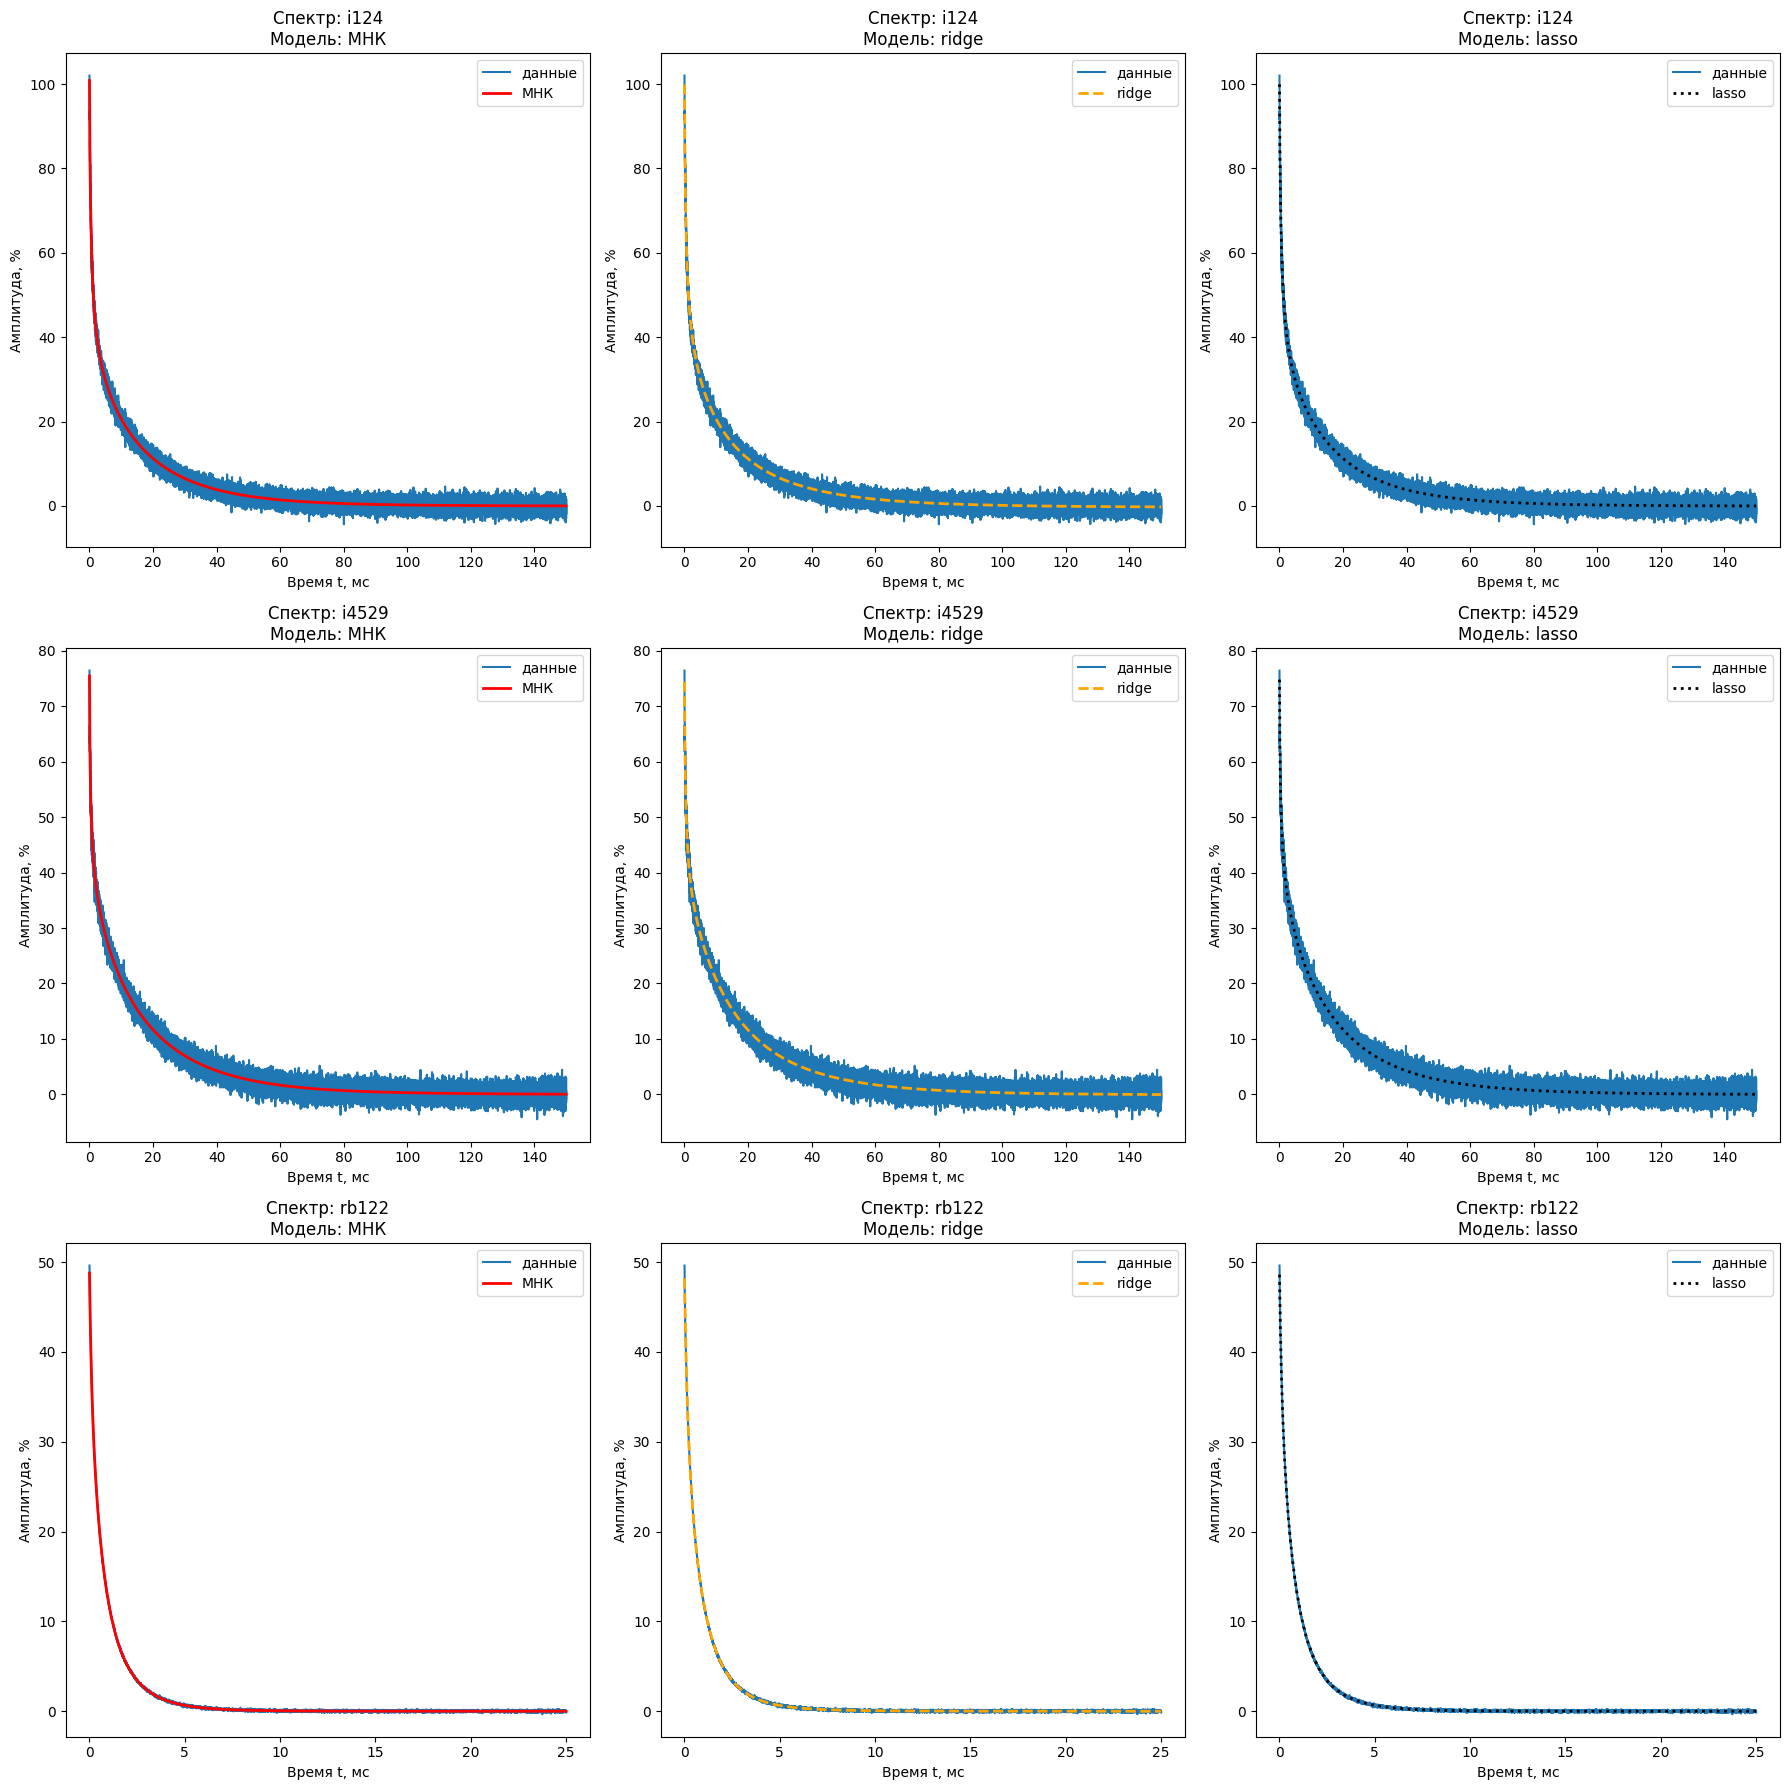

In [93]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, (data, name, lr, r, l) in enumerate(zip(spectrums, spectrums_names, LRs, rigde_model, lasso_model)):
    model_list = [(lr, 'r', 'МНК', '-'),
                  (r, 'orange', 'ridge', '--'),
                  (l, 'k', 'lasso', ':')]

    for j, (model, color, label, linestyle) in enumerate(model_list):
        ax = axes[i, j] 
        ax.plot(data.X, data.Y, label='данные')
        ax.plot(data.X, model.predict(et_T2(data.X.to_numpy().reshape(-1, 1), T2)), color=color, linestyle=linestyle, lw=2, label=label)

        ax.set_ylabel('Амплитуда, %')
        ax.set_xlabel('Время t, мс')
        ax.legend()
        ax.set_title(f'Спектр: {name}\nМодель: {label}')

plt.tight_layout()
plt.show()

Изобразим рассчитываемые спектры T2 для всех образцов, полученные с помощью LinearRegressor, Lasso, Ridge

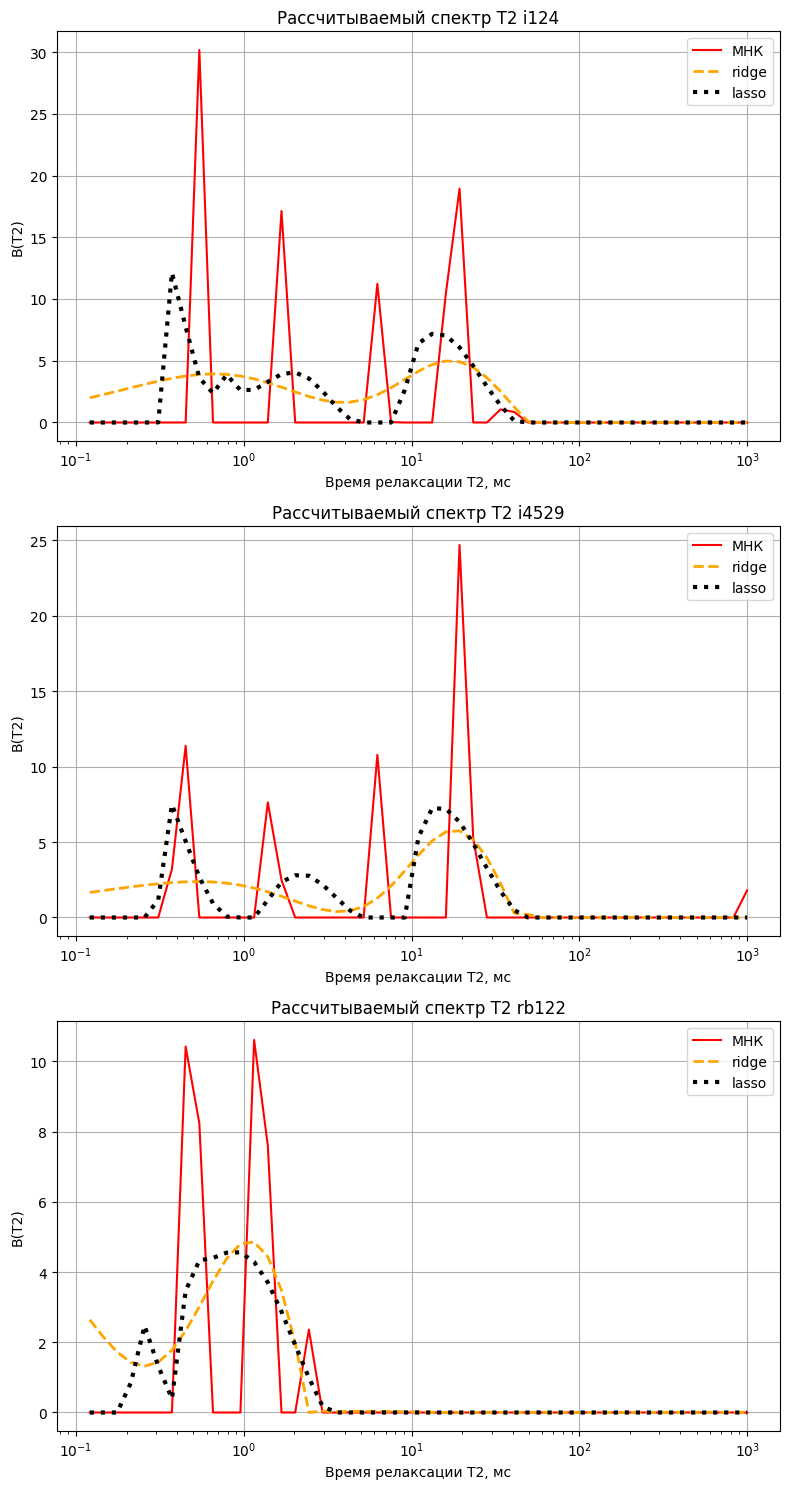

In [94]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15))


for ax, data, name, lr, r, l in zip(axes, spectrums, spectrums_names, LRs, rigde_model, lasso_model):

    ax.plot(T2[1:], lr.coef_.reshape(-1, 1)[1:], color='r', label='МНК')
    ax.plot(T2[1:], r.coef_.reshape(-1, 1)[1:], color='orange', linestyle='--', lw=2, label='ridge')
    ax.plot(T2[1:], l.coef_.reshape(-1, 1)[1:], ':k', lw=3, label='lasso')
    
    ax.semilogx()
    ax.set_xlabel('Время релаксации T2, мс')
    ax.set_ylabel('B(T2)')
    ax.set_title(f'Рассчитываемый спектр T2 {name}')
    ax.legend()
    ax.grid()

    

plt.tight_layout()
plt.show()